# Amplifying Noise on Optimized VQE Circuit (H2 at 0.74 ang via Simulator) by random addition of both single and 2 qubit gates 

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

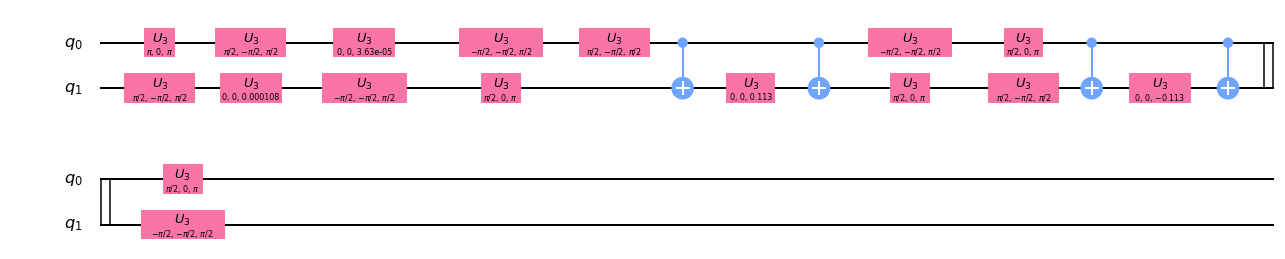

In [2]:
string = """OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nu3(pi,0,pi) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(0,0,3.6279236e-05) q[0];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[1];\nu3(0,0,0.00010816593) q[1];\nu3(-pi/2,-pi/2,pi/2) q[1];\nu3(pi/2,0,pi) q[1];\ncx q[0],q[1];\nu3(0,0,0.11268152) q[1];\ncx q[0],q[1];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,0,pi) q[0];\nu3(pi/2,0,pi) q[1];\nu3(pi/2,-pi/2,pi/2) q[1];\ncx q[0],q[1];\nu3(0,0,-0.11268152) q[1];\ncx q[0],q[1];\nu3(pi/2,0,pi) q[0];\nu3(-pi/2,-pi/2,pi/2) q[1];\n"""
vqe_circ = QuantumCircuit.from_qasm_str(string)
vqe_circ.draw(output = 'mpl')

### Functions for Noise Amplification

In [3]:
def u3PairAdder(orig_gate_str): 
    """
    Input: a qasm string corresponding to a gate
    Output: a pair of gates in qasm string representation to amplify error in the given gate by factor of 3
    """
    # Converting the gate string to array 
    
    ##break up the string 
    strings = orig_gate_str.split("(")
    temp =[]
    for string in strings: 
        temp = temp + string.split(")")
    strings = temp 
    temp =[]
    for string in strings: 
        temp = temp + string.split(",")
    strings = temp 
    temp = []
    for string in strings: 
        temp = temp + string.split("*")
    strings = temp
    
    #Obtaining all useful information 
    gate = strings[0]
    qubit = strings[4]
    orig_angles = strings[1:4]
    
    #inverting angles 
    invert_angles = orig_angles 
    for i in range(len(invert_angles)): 
        if invert_angles[i][0] == '-': 
            invert_angles[i] = '' + invert_angles[i][1:]
        elif invert_angles[i] != '0': 
            invert_angles[i] = '-' + invert_angles[i]
    

    #creating inverted gate
    invert_gate_str = gate + '(' + invert_angles[0] + ',' + invert_angles[1] + ',' + invert_angles[2] + ')' + qubit
    
    #barrier 
    barrier ="""barrier q[0],q[1];"""
    
    return barrier + '\n' + invert_gate_str + '\n'+ barrier + '\n' + orig_gate_str + '\n' + barrier + '\n'
    

In [4]:
def cXPairAdder(orig_gate_str): 
    """
    Input: a qasm string corresponding to a gate
    Output: a pair of gates in qasm string representation to amplify error in the given gate by factor of 3
    """
    #barrier for 2 qubit circuit only
    barrier ="""barrier q[0],q[1];"""
    
    return barrier + '\n' + orig_gate_str +'\n' +barrier + '\n'+orig_gate_str + '\n' + barrier + '\n'

In [5]:
import random 

def RandomAmplification(circ, c): 
    """
    Input: a circuit, and scaling factor between 1 and 3 (inclusive)
    Output: circuit with amplified error rate using adding-pair-of-gates tactic
    """
    
    #probability to add a pair of gates 
    g = (c-1)/2
    
    #iterating over the circuit in string representation
    
    
    newqasm_str=""
    circ_str=circ.qasm()
    
    qregname=circ.qregs[0].name
    
    for line in iter(circ_str.splitlines()):
        
        #cut out --- line.startswith('u3')
        if line.startswith('u3') :
            
            #doing a toss to see if we have to amplify 
            if random.randint(1,101) <= 100*g : 
                
                #adding the original line first 
                ##barrier 
                barrier ="""barrier q[0],q[1];"""
                newqasm_str+= barrier + '\n' + line + '\n'+ barrier + '\n'
                if line.startswith('cx'):
                    newqasm_str += cXPairAdder(line)
                else: 
                    newqasm_str += u3PairAdder(line)
            else: 
                newqasm_str+=line+"\n"
        else:
            newqasm_str+=line+"\n"

    circo=QuantumCircuit().from_qasm_str(newqasm_str)
    
    return circo 


### Hammyfication: Breaking Circuits into 2 copies, 1 for II, IZ, ZI and ZZ and the other for XX

In [6]:
from qiskit import ClassicalRegister
import math

Hamiltonian = """II
IZ 
ZI
ZZ
XX"""

Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]


circuits = []
for line in iter(Hamiltonian.splitlines()):
    circ = vqe_circ.copy()
    for index in range(len(line)):
        op = line[index]
        
        ##do nothing if Z or I
        if(op == "X"): 
            #hadamard in u3
            circ.u3(math.pi/2, 0, math.pi, index)
        elif(op == "Y"):
            circ.rx(pi/2, index)
    c = ClassicalRegister(2)
    circ.add_register(c)
    circ.measure([0], [0])
    circ.measure([1],[1])
    circuits.append(circ)

In [7]:
less_circuits = [circuits[0], circuits[4]]

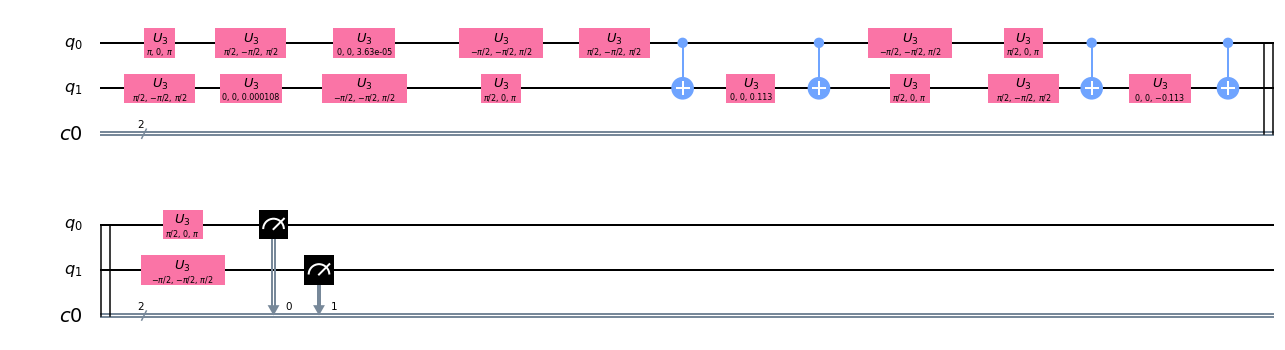

In [8]:
less_circuits[0].draw(output = 'mpl')

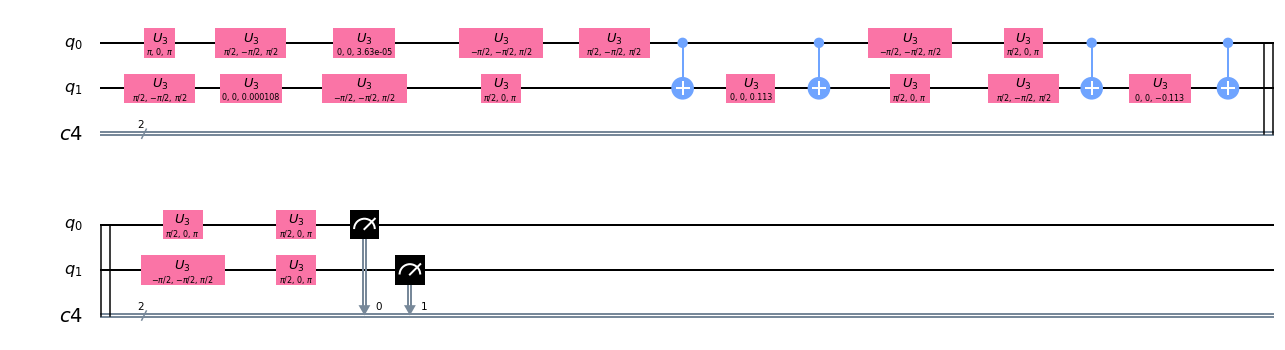

In [9]:
less_circuits[1].draw(output = 'mpl')
#hadamrd in u3 language

### Noise Amplification of Circuits

In [10]:
lots_scaled_circuits = []
n_samples = 100
scales = [1,1.5,2,2.5,3]

for c in scales:
    scale_circs = []
    print('------------------------------Starting Scale: ' +str(c) + ' ---------------------')
    
    for hammyfied_circ in less_circuits: 
        hammyfied_circs = []
        print( "Starting Hammified Circ")
        for i in range(n_samples):
            combo_circ = []
            circ = hammyfied_circ.copy()
            amp_circ = RandomAmplification(circ, c)
            hammyfied_circs.append(amp_circ)
        scale_circs.append(hammyfied_circs)
    lots_scaled_circuits.append(scale_circs)

------------------------------Starting Scale: 1 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 1.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 2 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 2.5 ---------------------
Starting Hammified Circ
Starting Hammified Circ
------------------------------Starting Scale: 3 ---------------------
Starting Hammified Circ
Starting Hammified Circ


### Expectation Value Functions

In [11]:
def binaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

In [12]:
def get_expec_val_H2(results, h, shots = 1024):
    keys = results.get_counts().keys()
    e_val = 0
    for key in keys:
        counts =int(results.get_counts()[key])
        
        key_val = int(key)
        key_dval = int(binaryToDecimal(key_val))
        
        ## II
        if (h==0):
            e_val += (int(counts)/shots)
        ## IZ
        elif (h==1):
            if (key_dval == 1 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
         ## ZI
        elif (h==2):
            if (key_dval == 2 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
        ## ZZ and XX(measured in ZZ basis)
        elif(h==3 or h==4):
            # 00 and 11 are +1 eigenvalues and others are -1
            if (key_dval == 0 or key_dval == 3):
                e_val += (int(counts)/shots)
            else:
                e_val += (-1)*(int(counts)/shots)
    return e_val
    

### Running Circuits

In [13]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance

provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmq_london')
noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')
noisy_sim = QuantumInstance(backend = simulator, noise_model = noise_model)

basis_gates = noise_model.basis_gates

In [14]:
from qiskit import execute 
from qiskit.compiler import transpile 
from qiskit.tools.monitor import job_monitor

lots_scaled_results = []
for scale_circs in lots_scaled_circuits:
    print('------------------------------Starting Scale ---------------------')
    scale_results = []
    for hammyfied_circs in scale_circs:
        print( "......................Starting Hammified Circs")
        hammyfied_results = []
        i=0
        for circ in hammyfied_circs: 
            circ = transpile(circ, basis_gates = basis_gates)
            job =  execute(circ, backend = simulator, noise_model = noise_model, shots = 1024)
            job_monitor(job)
            result = job.result()
            hammyfied_results.append(result)
        scale_results.append(hammyfied_results)
    lots_scaled_results.append(scale_results)

------------------------------Starting Scale ---------------------
......................Starting Hammified Circs
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully ru

### Resultifying Results: Turning counts to energy values

In [15]:
#Expectation Value
lots_scaled_values = []

for scale_results in lots_scaled_results: 
   
    scale_values = []
    n = 5 #if 5 hammys, then length is 5, 5th one is assumed to be XX
    for i in range(n): 
        hammyfied_vals = []
        if (i <4):
            c = 0
        else: 
            c= 1
        for result in scale_results[c]: 
            hammyfied_val = get_expec_val_H2(result, i)
            hammyfied_vals.append(hammyfied_val)
        scale_values.append(hammyfied_vals)
    lots_scaled_values.append(scale_values)

In [16]:
shift = 0.7151043390810812

lots_scaled_expec_vals = []
for scale_values in lots_scaled_values:
    scale_expec_vals = []
    for s in range(n_samples):
        exp_val = 0
        for h in range(len(Hamiltonian_weights)):
            exp_val += (Hamiltonian_weights[h])*(scale_values[h][s])
        #adding in shift (nuclear attraction energy)
        exp_val+=shift
        scale_expec_vals.append(exp_val)
    lots_scaled_expec_vals.append(scale_expec_vals)

In [17]:
import numpy as np
#Finding means 
means = []
std_devs = []
errs_on_mean = []
for scale_expec_vals in lots_scaled_expec_vals:
    mean = np.mean(scale_expec_vals)
    means.append(mean)
    std = np.std(scale_expec_vals)
    std_devs.append(std)
    err = std/np.sqrt(n_samples)
    errs_on_mean.append(err)

In [18]:
means 

[-1.0558696648251686,
 -0.3493660320126687,
 -0.32694403982516884,
 -0.3076091570126687,
 -0.9783072820126687]

In [19]:
std_devs

[0.011657571307427866,
 0.5037308635584188,
 0.4994222230989667,
 0.46200556699063233,
 0.1910811397602456]

In [20]:
errs_on_mean

[0.0011657571307427867,
 0.05037308635584188,
 0.04994222230989667,
 0.046200556699063235,
 0.01910811397602456]

### Plotting Results

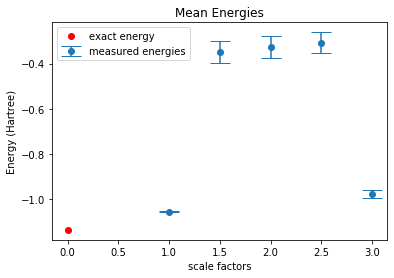

In [21]:
import matplotlib.pyplot as plt
#Plotting the results 
vqe_mean = means
vqe_std = std_devs
vqe_err  = errs_on_mean

#Plotting means 
plt.figure()
plt.errorbar(scales, vqe_mean, yerr=vqe_err,capsize = 10, fmt ='o', label = 'measured energies' )
plt.plot(0, -1.137, 'ro', label = 'exact energy')

plt.title('Mean Energies')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

In [22]:
lots_scaled_expec_vals


[[-1.0801046452939187,
  -1.0641964421689187,
  -1.0571983952939188,
  -1.0593194890439188,
  -1.0776300359189188,
  -1.0706124577939187,
  -1.0580011296689187,
  -1.0622140202939188,
  -1.0746105046689187,
  -1.058602692168919,
  -1.0421124577939187,
  -1.0590851140439188,
  -1.047911285918919,
  -1.0599405827939186,
  -1.0389835515439187,
  -1.054423004668919,
  -1.053907379668919,
  -1.0241886296689189,
  -1.0704210515439188,
  -1.035481598418919,
  -1.0872843327939188,
  -1.0681378484189186,
  -1.0621808171689189,
  -1.0651280827939187,
  -1.0634562077939187,
  -1.0588898015439188,
  -1.0303370671689187,
  -1.0602218327939186,
  -1.0529230046689189,
  -1.0582589421689188,
  -1.0426905827939186,
  -1.0560089421689187,
  -1.0596632390439187,
  -1.065729645293919,
  -1.0490870671689188,
  -1.0294718327939187,
  -1.061516754668919,
  -1.0541124577939187,
  -1.0587413640439187,
  -1.0599405827939188,
  -1.0670870671689185,
  -1.0378370671689188,
  -1.0634034734189186,
  -1.0560089421689

(array([ 2.,  2.,  7., 18., 28., 17., 11.,  8.,  4.,  3.]),
 array([-1.08728433, -1.08097476, -1.07466519, -1.06835562, -1.06204605,
        -1.05573648, -1.04942691, -1.04311734, -1.03680777, -1.0304982 ,
        -1.02418863]),
 <a list of 10 Patch objects>)

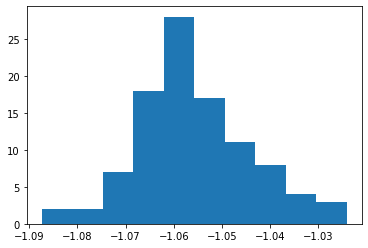

In [23]:
plt.hist(lots_scaled_expec_vals[0])

(array([27.,  0.,  0.,  0., 37., 10.,  0.,  0.,  0., 26.]),
 array([-1.07989371, -0.93046949, -0.78104527, -0.63162105, -0.48219683,
        -0.33277261, -0.1833484 , -0.03392418,  0.11550004,  0.26492426,
         0.41434848]),
 <a list of 10 Patch objects>)

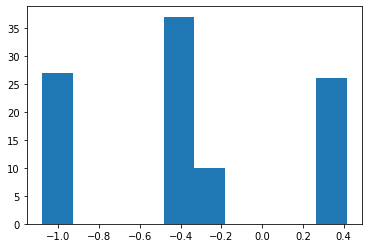

In [24]:
plt.hist(lots_scaled_expec_vals[1])

(array([25.,  0.,  0.,  0., 35., 13.,  0.,  0.,  0., 27.]),
 array([-1.08256949, -0.93381207, -0.78505465, -0.63629722, -0.4875398 ,
        -0.33878238, -0.19002496, -0.04126754,  0.10748989,  0.25624731,
         0.40500473]),
 <a list of 10 Patch objects>)

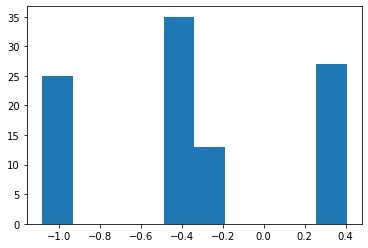

In [25]:
plt.hist(lots_scaled_expec_vals[2])

(array([20.,  0.,  0.,  0., 41., 14.,  0.,  0.,  0., 25.]),
 array([-1.07932535, -0.93013375, -0.78094215, -0.63175054, -0.48255894,
        -0.33336734, -0.18417574, -0.03498414,  0.11420746,  0.26339907,
         0.41259067]),
 <a list of 10 Patch objects>)

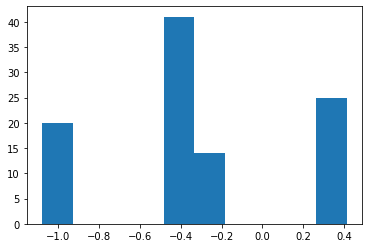

In [26]:
plt.hist(lots_scaled_expec_vals[3])

(array([86.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  7.]),
 array([-1.07587222, -1.00024566, -0.9246191 , -0.84899254, -0.77336597,
        -0.69773941, -0.62211285, -0.54648629, -0.47085972, -0.39523316,
        -0.3196066 ]),
 <a list of 10 Patch objects>)

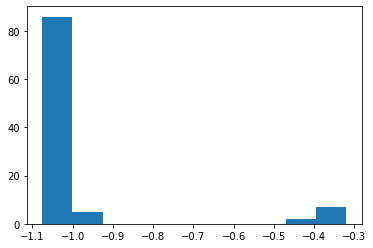

In [27]:
plt.hist(lots_scaled_expec_vals[4])

(array([27.,  0.,  0.,  0., 37., 10.,  0.,  0.,  0., 26.]),
 array([-1.07989371, -0.93046949, -0.78104527, -0.63162105, -0.48219683,
        -0.33277261, -0.1833484 , -0.03392418,  0.11550004,  0.26492426,
         0.41434848]),
 <a list of 10 Patch objects>)

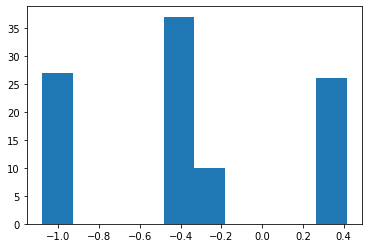

In [28]:
plt.hist(lots_scaled_expec_vals[1])